In [1]:
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

import matplotlib
matplotlib.rcParams['figure.figsize'] = (9, 6)

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from astropy import units as u
from astropy import coordinates as coord
from astropy.table import Column
from astroquery.vizier import Vizier

<h1 align="center">“<em>Crossmatching a catalogue of galaxies with bright stars base on their magnitude</em>”<br /> 
or “<em>Playing with indices</em>”</h1> 
<h2 align="center">LAM Hack-hour - 16/06/2016</h2> 

## Excuse

We have a dense catalogue of galaxies in which we want to flag those that are
near bright stars (because they may corrupt their magnitude).  We want the
flagging radius to be dependent on the r magnitude of the stars, with the
prescription:

$$radius[arcsec] = \exp(-0.43 * r_{mag} + 8.4)$$

_Don't worry, it's only an excuse to play with numpy array indices._

## Reminder: indexing with a list of indexes

Numpy arrays may be indexed with a list of integers corresponding to the indexes
of the elements you want ([see
documentation](http://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays)).

In [3]:
number_names = np.array(['zero', 'one', 'two', 'three', 'four', 'five'])
print(number_names[[3, 0, 0, 1, 2, 5, 5, 4]])

['three' 'zero' 'zero' 'one' 'two' 'five' 'five' 'four']


## Getting the catalogues

We will use the SDSS9 catalogue as a dense catalogue of galaxies, and will use
the Tycho-2 catalogue to get our stars.  We get these catalogues directly from
Vizier.

In [4]:
Vizier.ROW_LIMIT = -1  # If we don't do that, Vizier only send 50 rows.
region_center = coord.SkyCoord(34.8*u.deg, -4.4*u.deg)
sdss9, tycho2 = Vizier.query_region(region_center, width="40m", catalog=['sdss9', 'tycho2'])

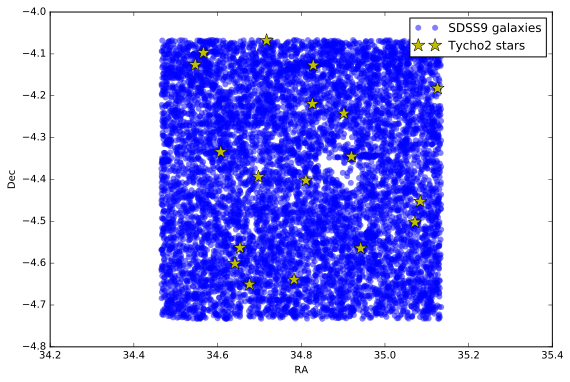

In [6]:
plt.plot(sdss9['RAJ2000'], sdss9['DEJ2000'], "bo", 
         markeredgecolor='None', alpha=.5, label="SDSS9 galaxies")
plt.plot(tycho2['RAmdeg'], tycho2['DEmdeg'], "y*", 
         label="Tycho2 stars", markersize=14)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.axis('equal')
plt.legend()

## Preparing the catalogues

The Tycho-2 catalogue does not provide the r magnitude. We compute it using the
formula:

$$ r_{mag} = VT_{mag} - 0.01 - 0.57545 * (BT_{mag} - VT_{mag})$$

Also, because some stars may have an important proper motion we correct the
J2000 position of the Tycho catalogue to compute the position at the time the
SDSS9 data was observed.

We store the position in astropy's `SkyCoord` object.

In [7]:
print("The SDSS9 data was observed in {}.".format(np.int(np.mean(sdss9['ObsDate']))))

The SDSS9 data was observed in 2008.


In [8]:
# Correcting the star position with their proper motions.
# Note: we convert the columns to arrays because of a bug
star_ra = (np.array(tycho2['RAmdeg']) + np.array(tycho2['pmRA']) /
           1000. / 3600. / np.cos(np.deg2rad(np.array(tycho2['DEmdeg'])))
           * (2008-2000))
star_dec = (np.array(tycho2['DEmdeg']) + np.array(tycho2['pmDE']) / 
            1000. / 3600. * (2008-2000))

# Star positions.
star_pos = coord.SkyCoord(star_ra * u.degree, star_dec * u.degree)

# Star r magnitudes
star_rmag = tycho2['VTmag'] - 0.01 - 0.57545 * (tycho2['BTmag'] - tycho2['VTmag'])

# Mask radius associated to each star
star_rmag.unit = None
star_mask_rad = np.exp(-0.43 * star_rmag + 8.4) * u.arcsec

# The SDSS9 catalogue positions
galaxy_pos = coord.SkyCoord(sdss9['RAJ2000'], sdss9['DEJ2000'])

## Cross-matching

The ``SkyCoord`` object provide a `search_around_sky` method to cross-match the
position against another `SkyCoord` object (_execute the following cell to
display the documentation_).

In [8]:
coord.SkyCoord.search_around_sky?

The `search_around_sky` method only takes one value of search radius, although
we need a different search radius per star. First, we make a cross-match with
the maximal radius.

In [9]:
idx_galaxy, idx_star, d2d, _ = star_pos.search_around_sky(galaxy_pos, np.max(star_mask_rad))

In [14]:
np.max(star_mask_rad)

<Quantity 279.2743225097656 arcsec>

In [12]:
d2d

<Angle [ 0.07410217, 0.06844478, 0.07728294,...,  0.07585711, 0.07391087,
         0.07135511] deg>

We have three arrays representing the triplets:
- The index of the galaxy in the SDSS9 catalogue;
- The index of the star in the Tycho-2 catalogue;
- The 2d distance (arcsec) between the star and the galaxy.

As we cross-matched with the maximal distance, we have to get rid of the
galaxies that are near a star but not near enough with regard to the star
magnitude.

# Exercice

If you downloaded this notebook before the hackhour, this is an exercise for you. Compute the list of the indexes of the galaxy that are near enough of a bright star with regard to its magnitude. Put this list in `to_flag_idx_galaxy`. Don't worry, you'll have the solution during the hackhour.

_**Hint**: the reminder above is not here by chance..._

In [10]:
to_flag_idx_galaxy = 

# Flagging the sources

We add a `mask_tycho2` column filled with 0 and we set this column to 1 for the
galaxies to flag.

In [10]:
sdss9.add_column(Column(data=np.zeros(len(sdss9)), name="mask_tycho2", dtype=np.int))
sdss9['mask_tycho2'][to_flag_idx_galaxy] = 1

NameError: name 'to_flag_idx_galaxy' is not defined

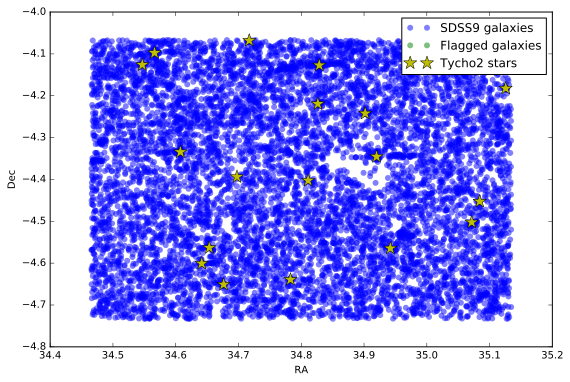

In [11]:
plt.plot(sdss9['RAJ2000'], sdss9['DEJ2000'], "bo", 
         markeredgecolor='None', alpha=.5, label="SDSS9 galaxies")
plt.plot(sdss9['RAJ2000'][sdss9['mask_tycho2'] == 1], 
         sdss9['DEJ2000'][sdss9['mask_tycho2'] == 1], 
         "go", markeredgecolor='None', alpha=.5,
         label="Flagged galaxies")
plt.plot(tycho2['RAmdeg'], tycho2['DEmdeg'], "y*", 
         label="Tycho2 stars", markersize=14)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.legend()